Importing important libraries

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import copy
from tabulate import tabulate

Reading image and creating a corresponding array containg pixel values

In [3]:
def read_image():
    img_path= input("Enter the path of the image: ")
    img=Image.open(img_path)
    gray_image = img.convert('L')
    img_array = np.array(gray_image)
    plt.imshow(img_array, cmap='gray')
    plt.title('Imported Image')
    plt.axis('off')
    plt.show()
    return img_array

Creating binary matrix with 1's and 0's based on pixels of given points

In [4]:
def create_bin_matrix(img_array):
    bin_matrix = (img_array >= 200).astype(int)
    return bin_matrix

Creating a Data Frame containing columns x and y to store the white points indices

In [5]:
def create_data_frame():
    img_array = read_image()
    bin_matrix = create_bin_matrix(img_array)
    idx_white_points = np.argwhere(bin_matrix == 1)
    df = pd.DataFrame(idx_white_points, columns=['x', 'y'])
    return df

Implementing K-Means clustering algorithm 

In [6]:
def k_means(k, df, image_width, image_height):
    min_var = float('inf')
    final_centeroids = None
    final_df = None

    for i in range(10):
        centeroids = generate_centeroids(k, image_width, image_height)
        df = assignment(df, centeroids, color_map)
        while True:
            prev_closest = df['closest'].copy()
            centeroids = update_centeroids(df, centeroids, image_width, image_height)
            df = assignment(df, centeroids, color_map)
            if prev_closest.equals(df['closest']):
                break
        total_var = variation(df, centeroids)
        if total_var < min_var:
            min_var = total_var
            final_centeroids = copy.deepcopy(centeroids)
            final_df = df.copy()
    return final_centeroids, final_df


Generating 'k' random Centeroids

In [7]:
def generate_centeroids(k, img_width, img_ht):
    centeroids = {}
    for i in range(k):
        centeroids[i + 1] = [np.random.randint(0, img_width), np.random.randint(0, img_ht)]
    return centeroids


Assigning each white point(city) to a centeroid

In [8]:
def assignment(df, centeroids, color_map):
    if df.empty:
        print("DataFrame is empty.")
        return df
        
    for i in centeroids.keys():
        df[f'distance_from_{i}'] = np.sqrt((df['x'] - centeroids[i][0])**2 + (df['y'] - centeroids[i][1])**2)
    centeroid_distance_cols = [f'distance_from_{i}' for i in centeroids.keys()]
    df['closest'] = df.loc[:, centeroid_distance_cols].idxmin(axis=1)
    df['closest'] = df['closest'].map(lambda x: int(x.lstrip('distance_from_')))
    df['color'] = df['closest'].map(lambda x: color_map[x])
    return df

Calculating total variation 

In [9]:
def variation(df, centeroids):
    var = 0
    for i in centeroids.keys():
        var += np.sum(np.sqrt((df[df['closest'] == i]['x'] - centeroids[i][0])**2 + (df[df['closest'] == i]['y'] - centeroids[i][1])**2))
    return var

Updating centeroids from previous clusters

In [10]:
def update_centeroids(df, centeroids, image_width, image_height):
    for i in centeroids.keys():
        points = df[df['closest'] == i]
        if not points.empty:
            centeroids[i] = [points['x'].mean(), points['y'].mean()]
        else:
            centeroids[i] = [np.random.randint(0, image_width), np.random.randint(0, image_height)]
    return centeroids

Get the optimal 'k' (elbow point)

In [11]:
def get_elbow_point(variance):
    dx = np.diff(list(variance.keys()))
    dy = np.diff(list(variance.values()))
    slope = dy / dx
    slope_diff = np.diff(slope)
    elbow_idx = np.argmax(slope_diff) + 1
    return elbow_idx

Calculating variation for multiple values of 'k'

In [12]:
def calc_variation_for_multiple_k(df, image_width, image_height, color_map):
    variance = {}
    for k in range(1, 9):
        centeroids, df = k_means(k, df, image_width, image_height)
        variance[k] = variation(df, centeroids)
    return variance

Plotting the graph for variation for different values of k

In [13]:
def plot_elbow_graph(variance):
    plt.plot(list(variance.keys()), list(variance.values()), marker='o')
    plt.title('Elbow Method Curve')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Total Variation')
    plt.grid(True)
    plt.show()

Code using above functions for clustering the cities

Enter the path of the image:  C:\Users\DELL\Downloads\3.png


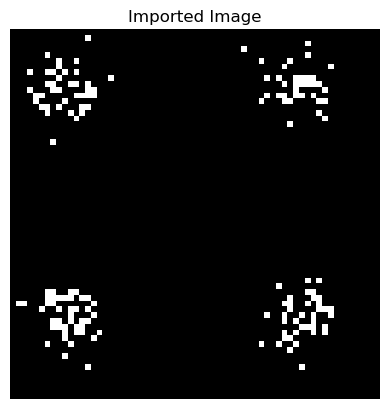

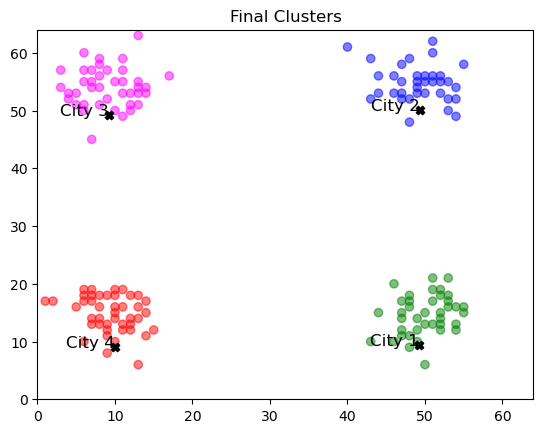

In [14]:
color_map = {1: 'red', 2: 'green', 3: 'blue', 4: 'magenta', 5: 'orange', 6:'brown', 7:'cyan', 8:'pink'}

image_height = 64
image_width = 64

df = create_data_frame()
variance = calc_variation_for_multiple_k(df, image_width, image_height, color_map)
k = get_elbow_point(variance) + 1
final_centeroids, final_df = k_means(k, df, image_width, image_height)
final_df['rotated_x']=final_df['y']
final_df['rotated_y']=image_width - final_df['x']


plt.scatter(final_df['rotated_x'], final_df['rotated_y'], color=final_df['color'], alpha=0.5)
for i in final_centeroids.keys():
    plt.scatter(*final_centeroids[i], color='black', marker='X')
    plt.text(final_centeroids[i][0], final_centeroids[i][1], f"City {i}", fontsize=12, ha='right')
plt.title("Final Clusters")
plt.xlim(0, 64)
plt.ylim(0, 64)
plt.show()


Finding distances between every 2 cities

In [15]:
distances = []
for i in final_centeroids.keys():
    for j in final_centeroids.keys():
        if i < j:
            distance = np.sqrt((final_centeroids[i][0] - final_centeroids[j][0])**2 + (final_centeroids[i][1] - final_centeroids[j][1])**2)
            distances.append([f'City {i}', f'City {j}', distance])            

print("Distances between cities:")
print(tabulate(distances, headers=['City A', 'City B', 'Distance'], tablefmt='grid'))


Distances between cities:
+----------+----------+------------+
| City A   | City B   |   Distance |
+==========+==========+============+
| City 1   | City 2   |    40.6074 |
+----------+----------+------------+
| City 1   | City 3   |    56.34   |
+----------+----------+------------+
| City 1   | City 4   |    39.2613 |
+----------+----------+------------+
| City 2   | City 3   |    40.1372 |
+----------+----------+------------+
| City 2   | City 4   |    56.8871 |
+----------+----------+------------+
| City 3   | City 4   |    40.1238 |
+----------+----------+------------+
